# TP auto-regressive image completion

Save the notebook as either PDF or HTML and make sure all the results are saved correctly (I won't run them and the original format does not save the results automatically), **and put your name in the filename**.

<div class="alert alert-success"> 
<b>Questions are in green boxes.</b>
The maximum time you should spend on each question is given as indication only. If you take more time than that, then you should come see me.
</div>
<div class="alert alert-info" role="alert"><b>Analyzes are in blue boxes.</b> You should comment on your results in theses boxes (Is it good? Is it expected? Why do we get such result? Why is it different from the previous one? etc)
</div>

In [14]:
import jax
import jax.numpy as jnp
import jax.nn as jnn
import numpy as np
import gzip
import pickle
import matplotlib.pyplot as plt
from functools import partial
from tqdm import tqdm
from einops import rearrange

For this lab, we will use the bluebell dataset. It consists of $64\times 64$ color images, which we will have to flatten into $12k$ dimensional vectors. The code for the dataset comes with several train/val/test splits.

0


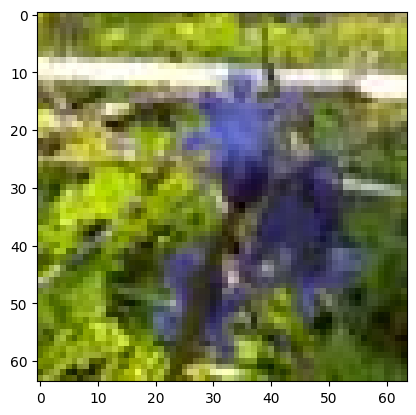

In [24]:
# Load the dataset
from bluebell import Bluebell
X_train_ds = Bluebell('bluebell_64', 'train', split=0)
X_val_ds = Bluebell('bluebell_64', 'val', split=0)
X_train = np.array([img.flatten()/127.5 - 1. for img, lab in X_train_ds])
y_train = np.array([lab for img, lab in X_train_ds])
X_val = np.array([img.flatten()/127.5 - 1. for img, lab in X_val_ds])
y_val = np.array([lab for img, lab in X_val_ds])
plt.imshow(X_train[0].reshape(64, 64, 3)/2+0.5)
print(y_train[0])

## Image tokenization

First, we want to transform the image into a sequence of discrete tokens to ease the prediction process. Predicting the $(r,g,b)$ triplet value of each pixels is too cumbersome, so instead we are going to patchify the image into a sequence of $4\times 4$ pixels and then quantize these patches with a dictionary so that we obtain a sequence of integer. Combining those process is called _tokenization_

The main appeal of tokenization is that it transforms the problem of pixel prediction into a classification problem: what is the index of the next token? This problem is much simpler to solve than the original (vector) regression problem.

We first write the 2 functions to transform an image into a sequence of patches and vice-versa.

In [25]:
def image_to_patches(X, k=4):
    X = rearrange(X, 'b (h w c) -> b h w c', h=64, w=64, c=3)
    X = rearrange(X, 'b (h m) (w n) c -> b (h w) (m n c)', m=k, n=k)
    return X

def patches_to_image(X, k=4):
    X = rearrange(X, 'b (h w) (m n c) -> b (h m) (w n) c', m=k, n=k, h=64//k, w=64//k)
    return X


In [26]:
X = image_to_patches(X_train)
print(f"The shape of X_train is {X_train.shape}")
print(f"The shape of X is {X.shape}")
Y = patches_to_image(X)
print(Y.shape)


The shape of X_train is (1200, 12288)
The shape of X is (1200, 256, 48)
(1200, 64, 64, 3)


Then, we want to create a dictionary of patches such that each patch can be replace by the integer corresponding to its closest match from the dictionary. To that end, we will use K-Means, thanks to sk-learn.


<div class="alert alert-success"> 
<b>Q1. Train a k-means clustering algorithm on the training set converted to sequences of patches.</b>
Then, create quantized version of the training and validation set called Xq_train and Xq_val respectively. Reconstruct some of the training images and compare them to the original images. For now on, we will consider only 16 clusters due to speed consideration, at the cost of degraded visual quality, but we can always go back to bigger dictionaries later. (should run in less than 3 minutes)
</div>

In [28]:
n_clusters = 16

In [29]:
Xp_train = image_to_patches(X_train)
Xp_val = image_to_patches(X_val)
print(f"Xp_train's shape is: {Xp_train.shape}")
print(f"Xp_val's shape is: {Xp_val.shape}")

Xp_train_patches = Xp_train.reshape(Xp_train.shape[0]*Xp_train.shape[1], 48)
print(f"Xp_train_patches' shape is {Xp_train_patches.shape}")

Xp_train's shape is: (1200, 256, 48)
Xp_val's shape is: (300, 256, 48)
Xp_train_patches' shape is (307200, 48)


In [30]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=n_clusters)
kmeans.fit(Xp_train_patches)

KMeans(n_clusters=16)

In [22]:
num_samples, patches, d = Xp_train.shape
Xq_train = kmeans.predict(Xp_train_patches).reshape(num_samples, patches)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8933445..0.6936174].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8933445..0.7850634].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8483025..0.6936174].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8933445..0.6936174].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8933445..0.6936174].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8933445..0.7850634].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.893344

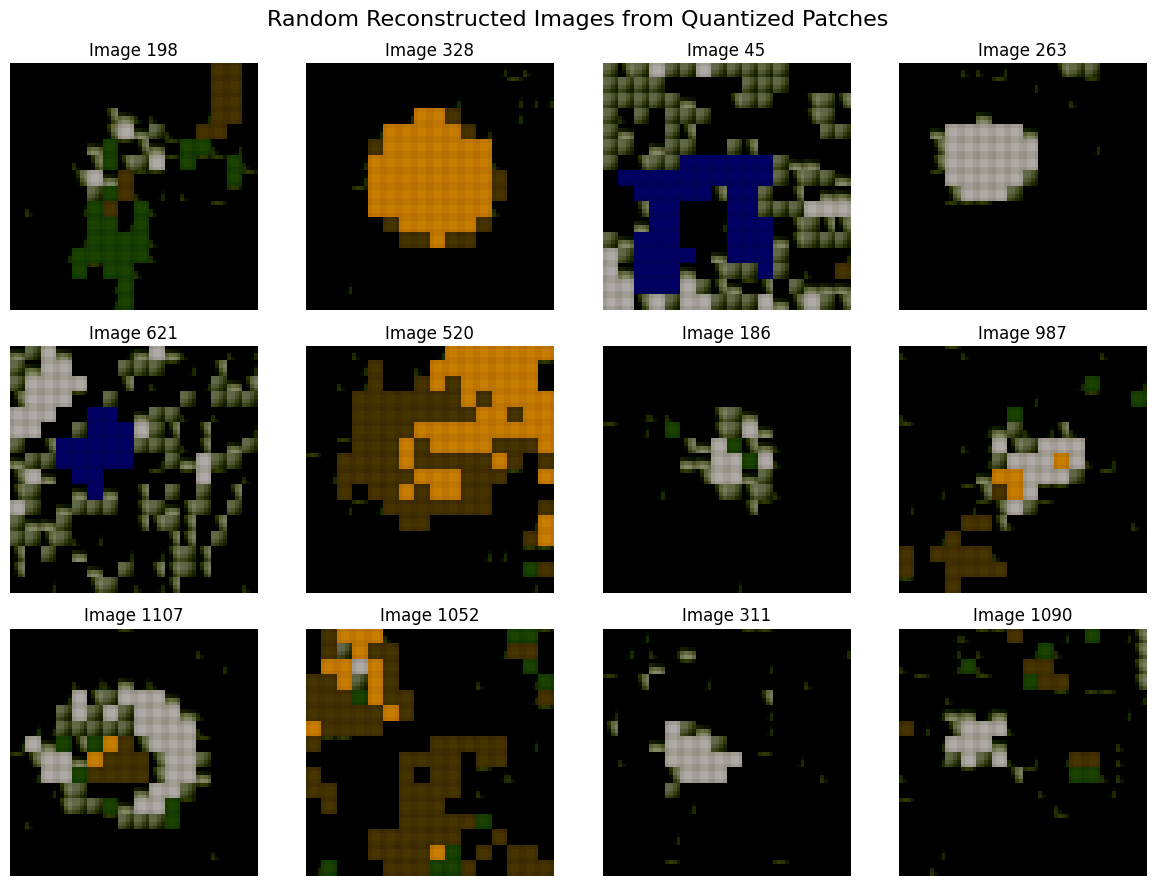

In [ ]:

centroids = kmeans.cluster_centers_
num_samples, patches, d = Xp_train.shape
Xq = jnp.zeros((num_samples, patches))
for i in range(num_samples):
    X_sample = Xp_train[i,:,:] #shape (256, 48)
    diff = (X_sample[:, None, :] - centroids[None, :, :]).transpose(0, 2, 1) #shape (256, 48, 16)
    diff = jnp.sum(diff**2,axis=1) #shape (256, 16)
    X_quantized = jnp.argmin(diff, axis=1) #shape (256,)
    Xq = Xq.at[i,].set(X_quantized) 
    
print()
np.random.seed(0)
Xq = Xq.astype(jnp.int32)  # or jnp.int64 if needed
centroids = jnp.array(centroids)
X_images = centroids[Xq]  # Xq should be shape (num_samples, patches)
X_original = patches_to_image(X_images)
# Convert JAX array to NumPy for plotting
X_original_np = np.array(X_original)

# Randomly select 12 unique indices from the dataset
num_samples = X_original_np.shape[0]
random_indices = np.random.choice(num_samples, size=12, replace=False)

# Create figure
fig, axes = plt.subplots(3, 4, figsize=(12, 9))
fig.suptitle("Random Reconstructed Images from Quantized Patches", fontsize=16)

# Loop through 12 randomly chosen images
for i, idx in enumerate(random_indices):
    row = i // 4
    col = i % 4
    ax = axes[row, col]
    ax.imshow(X_original_np[idx])
    ax.axis('off')
    ax.set_title(f"Image {idx}")

plt.tight_layout()
plt.subplots_adjust(top=0.92)  # Make room for title
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..

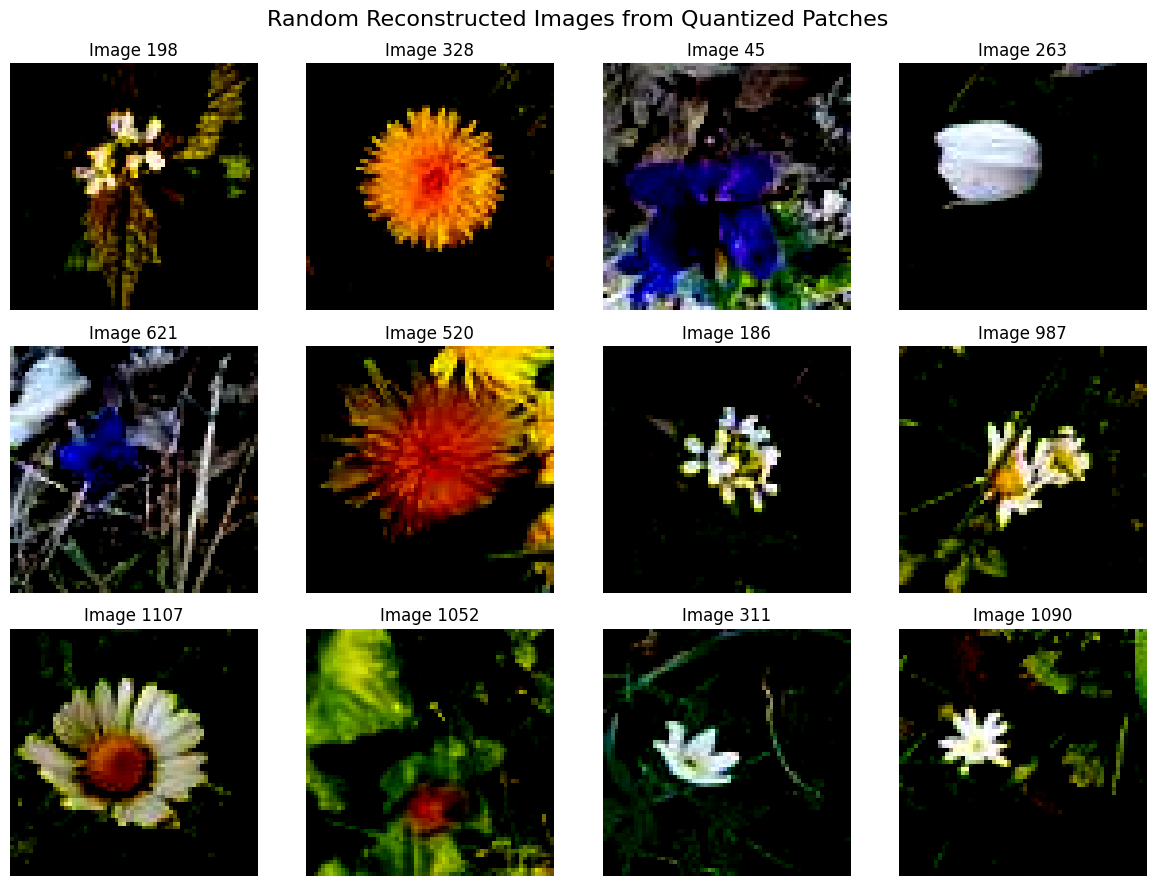

In [10]:
# Randomly select 12 unique indices from the dataset
np.random.seed(0)
num_samples = Y.shape[0]
random_indices = np.random.choice(num_samples, size=12, replace=False)

# Create figure
fig, axes = plt.subplots(3, 4, figsize=(12, 9))
fig.suptitle("Random Reconstructed Images from Quantized Patches", fontsize=16)

# Loop through 12 randomly chosen images
for i, idx in enumerate(random_indices):
    row = i // 4
    col = i % 4
    ax = axes[row, col]
    ax.imshow(Y[idx])
    ax.axis('off')
    ax.set_title(f"Image {idx}")

plt.tight_layout()
plt.subplots_adjust(top=0.92)  # Make room for title
plt.show()

In [13]:
print(Xp_val.shape)

(300, 256, 48)


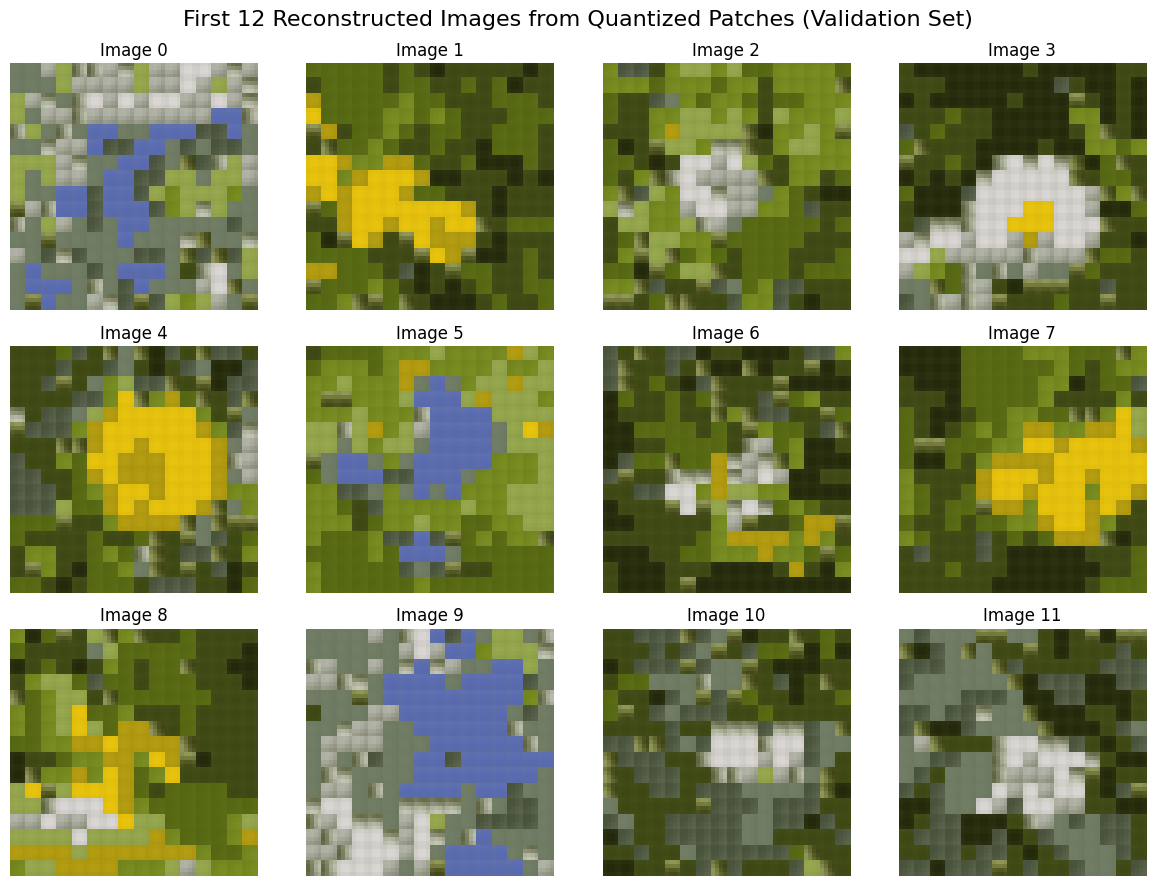

In [32]:
centroids = kmeans.cluster_centers_
num_samples, patches, d = Xp_val.shape
Xq = jnp.zeros((num_samples, patches))

for i in range(num_samples):
    X_sample = Xp_val[i, :, :]  # shape (n_patches, patch_dim)
    diff = (X_sample[:, None, :] - centroids[None, :, :]).transpose(0, 2, 1)  # shape (n_patches, patch_dim, n_clusters)
    diff = jnp.sum(diff**2, axis=1)  # shape (n_patches, n_clusters)
    X_quantized = jnp.argmin(diff, axis=1)  # shape (n_patches,)
    Xq = Xq.at[i, :].set(X_quantized)

print()
Xq = Xq.astype(jnp.int32)
centroids = jnp.array(centroids)
X_images = centroids[Xq]  # shape (num_samples, n_patches, patch_dim)
X_original = patches_to_image(X_images)

# Convert JAX array to NumPy for plotting
X_original_np = np.array(X_original) 
X_original_np = (X_original_np+1)/2

# Sélection des 12 premières images
random_indices = np.arange(12)

# Create figure
fig, axes = plt.subplots(3, 4, figsize=(12, 9))
fig.suptitle("First 12 Reconstructed Images from Quantized Patches (Validation Set)", fontsize=16)

# Loop through 12 chosen images
for i, idx in enumerate(random_indices):
    row = i // 4
    col = i % 4
    ax = axes[row, col]
    ax.imshow(X_original_np[idx])
    ax.axis('off')
    ax.set_title(f"Image {idx}")

plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.show()


<div class="alert alert-info" role="alert"><b>Analyzes are in blue boxes.</b> You should comment on your results in theses boxes (Is it good? Is it expected? Why do we get such result? Why is it different from the previous one? etc)
</div>

### Linear model

We first consider a linear model over the past $k$ tokens, of the form

$$ f(x_{n-k}, ..., x_n) = W_o^\top \sum_j \alpha_m W_i[x_{n-m}] + \beta[y] $$

with $x_n$ the token at location $n$ taken in raster scan order and $y$ the class associated with the image. In this model, we first transform the token $x_n$ into a vector thanks to an embedding matrix $W_i$ (which can be done in matrix product with a one-hot encoding of $x_n$). We also transform the class of the image $y$ into the same feature space with another embedding matrix $\beta$. Then, we compute a weighted sum of those features thanks to parameters $\alpha$. Finally, we predict the class of the next token with the linear classifier $W_o$.

To train this model, we need a classification loss. We can use the categorical cross-entropy, which is well suited as the targets are exclusive: 

$$ \min -x_n\log (f(x_{n-k-1}, ..., x_{n-1})[x_n]) $$

which can be computed with jnn.log_softmax.

<div class="alert alert-success"> 
<b>Q2. in the following ARPredictor class, write the pred function.</b>
Notice that the parameters are provided in a dictionary as created in the constructor of the class. Since the model is linear, everything can be done with some matmuls, sums and swapaxes. Run your method on some images, just to make sure all sizes are correct and in the right order. (indicative time, should run in less than a second after compiling).
</div>

In [33]:
k = 128

In [ ]:
class ARPredictor():
    def __init__(self, k, dim, n_clusters):
        self.k = k
        self.dim = dim
        self.n_clusters = n_clusters
        self.params = {
            "w_in": np.random.randn(n_clusters, dim)/(dim+n_clusters),
            "alpha": np.random.randn(k),
            "beta": np.random.randn(12, dim),
            "w_out": np.zeros((dim, n_clusters)), #np.random.randn(dim, n_clusters)/np.sqrt(dim+n_clusters),
            "b_out": -np.ones(n_clusters) * np.log(n_clusters)
        }

    def predict(self, X, z):
        return ARPredictor.pred(self.params, jnn.one_hot(X, self.n_clusters), jnn.one_hot(z, 12))

    @staticmethod
    @jax.jit
    # X probably of shape (batch_size, k, 16)
    # y probably of shape (batch_size, 12)
    def pred(params, X, z):
        print(f"the shape of X is {X.shape}")
        print(f"the shape of z is {z.shape}")
        X_results = jnp.argmax(X, axis = 2) # (batch_size, k)
        print(f"the shape of X_results is {X_results.shape}")
        y_results = jnp.argmax(z, axis = 1) #(batch_size, 1)
        print(f"the shape of y_results is {y_results.shape}")

        W_in_results = params["w_in"][X_results] #(batch_size, k, dim)
        print(f"the shape of W_in_results is {W_in_results.shape}")
        beta_results = params["beta"][y_results] #(batch_size, dim)
        print(f"the shape of beta_results is {beta_results.shape}")

        W_in_results = jnp.swapaxes(W_in_results,1,2)*params["alpha"] #(batch_size, dim, k)
        print(f"the new shape of W_in_results is {W_in_results.shape}")
        Y_in_results = jnp.swapaxes(jnp.sum(W_in_results, 2), 0, 1) #(dim, batch_size)
        print(f"the shape of Y_in_results is {Y_in_results.shape}")

        results = jnp.matmul(params["w_out"].T, Y_in_results + jnp.swapaxes(beta_results,0,1)).T #(batch_size, n_clusters)
        print(f"the shape of results is {results.shape}")
        return results

    @staticmethod
    @jax.jit
    def xe(params, X, y, z):
        y_pred = ARPredictor.pred(params, X, z)
        l = -(jnn.log_softmax(y_pred)*y).sum(axis=-1).mean()
        return l

    @staticmethod
    @jax.jit
    def update(params, X, y, z, eta=0.01):
        l, g = jax.value_and_grad(ARPredictor.xe, argnums=(0))(params, X, y, z)
        for k in params.keys():
            #print(f"{k}: {params[k]} g: {g[k]}")
            params[k] = params[k] - eta * g[k]
        return l, params

    
    def fit(self, X, y, n_iter=1000, batch_size=256, eta=0.01):
        n = X.shape[1]
        losses = []

        for it in range(n_iter):
            idx = np.random.randint(0, X.shape[0], size=batch_size)
            X_batch = X[idx]
            y_batch = y[idx]

            t = np.random.randint(0, n - self.k - 1)

            X_input = jnn.one_hot(X_batch[:, t:t+self.k], self.n_clusters)
            X_target = jnn.one_hot(X_batch[:,t+self.k], self.n_clusters)

            z_batch = jnn.one_hot(y_batch, 12)

            loss, self.params = ARPredictor.update(self.params, X_input, X_target, z_batch, eta=eta)
            losses.append(loss)

            if it % 100 == 0:
                print(f"[{it}] loss : {loss:.4f}")
        

        plt.plot(losses)
        plt.title("Training loss")
        plt.xlabel("Iteration")
        plt.ylabel("Cross-Entropy Loss")
        plt.show()
           
            
        return losses

    # X_init of shape k 

    def gen_ar(self, X_init, z, km, seed=3407):
        n_tokens = 256
        k = self.k
        n_clusters = self.n_clusters

        tokens = list(X_init)  # initial sequence of shape (k,)

        key = jax.random.PRNGKey(seed)

        for _ in range(len(X_init), n_tokens):
            # Use last k tokens as context, add batch dimension
            context = jnp.array(tokens[-k:])[None, :]  # shape: (1, k)
            class_label = jnp.array([z])               # shape: (1,)

            # Get logits from the model
            logits = self.predict(context, class_label)  # shape: (1, n_clusters)
            logits = logits[0]  # remove batch dim

            # Sample next token
            key, subkey = jax.random.split(key)
            next_token = int(jax.random.categorical(subkey, logits))
            tokens.append(next_token)

        # Convert token indices to patches using k-means centers
        patches = km.cluster_centers_[tokens]         # shape: (256, 48)
        patches = jnp.array(patches)[None, :, :]      # shape: (1, 256, 48)

        # Reconstruct the full image
        image = patches_to_image(patches)             # shape: (1, 64, 64, 3)

        return image


In [36]:
%%time
arp = ARPredictor(k, dim=64, n_clusters=n_clusters)

CPU times: total: 0 ns
Wall time: 247 μs


In [11]:
%%time
arp = ARPredictor(k, dim=64, n_clusters=n_clusters)

CPU times: user 143 μs, sys: 13 μs, total: 156 μs
Wall time: 160 μs



<div class="alert alert-success"> 
<b>Q3. Write the generation method.</b>
The generation method (gen_ar) takes as argument the start of a sequence and their class and generates the rest of the sequence. It thus loops over the missing tokens and calls the predict method with the last $k$ elements of the sequence. This returns a set of logits from which we have to sample a class (ie, the index in the dictionary of the next token). We can do this using the jax.random.categorial function which is why there is a seed in the argument of the function. Last, the sequence of indices is converted back to an image and returned. (generating should take less than 30 seconds). Run it on a just initialized model. You should get complete random patterns after the begining of the image.
</div>

the shape of X is (1, 128, 16)
the shape of z is (1, 12)
the shape of X_results is (1, 128)
the shape of y_results is (1,)
the shape of W_in_results is (1, 128, 60)
the shape of beta_results is (1, 60)
the new shape of W_in_results is (1, 60, 128)
the shape of Y_in_results is (60, 1)
the shape of results is (1, 16)


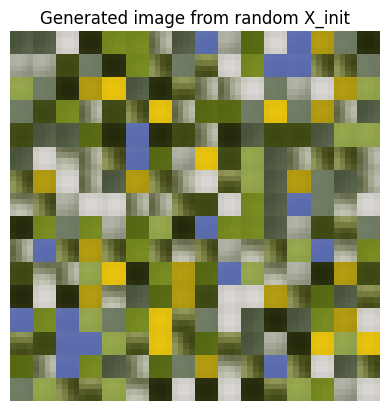

In [37]:
# Create the model
dim = 60
model = ARPredictor(k=k, dim=dim, n_clusters=n_clusters)

# Randomly generate initial tokens (shape: (k,))
X_init = np.random.randint(0, n_clusters, size=(k,))

# Random class label (integer in [0, 11])
z = np.random.randint(0, 12)
# Generate image using the untrained model
generated_image = model.gen_ar(X_init, z, kmeans)  # shape: (1, 64, 64, 3)

generated_image = (generated_image+1)/2
# Show the result
plt.imshow(np.clip(np.array(generated_image[0]), 0, 1))
plt.axis('off')
plt.title("Generated image from random X_init")
plt.show()

<div class="alert alert-info" role="alert"><b>Analyzes are in blue boxes.</b> You should comment on your results in theses boxes (Is it good? Is it expected? Why do we get such result? Why is it different from the previous one? etc)
</div>


<div class="alert alert-success"> 
<b>Q4. Write the fit method.</b>
To train the model, we will perform SGD. We randomly sample mini-batches from X, randomly sample a timestep $t$ to crop the sequence between $t$ and $t+k-1$ and try to predict the value at $t+k$. We do this for a number of iterations and store the updates parameters in the model. We plot the loss value to verify that the loss decreases on average. Then, we generate a few image starting from the begining of Xq_val to check that we have something that is less random than the model at initialization.
</div>

x: (12, 128)


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [00:00<00:00, 471.05it/s]


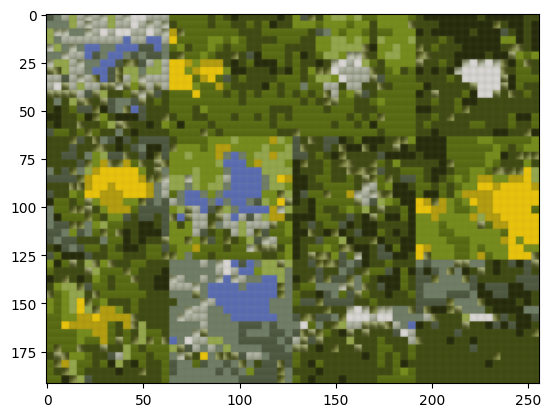


<div class="alert alert-info" role="alert"><b>Analyzes are in blue boxes.</b> You should comment on your results in theses boxes (Is it good? Is it expected? Why do we get such result? Why is it different from the previous one? etc)
</div>


<div class="alert alert-info" role="alert"><b>Analyzes are in blue boxes.</b> You should comment on your results in theses boxes (Is it good? Is it expected? Why do we get such result? Why is it different from the previous one? etc)
</div>

### Transformers

We now want to consider a more capable model: the transformer.

Transformers are built around masked softmax attention, which combines tokens using weights from a normalized dot-product. Given 3 projection $W_q, W_k$ and $W_v$, we have

$$ Q = XW_q, K = XW_k, V = XW_v, $$
$$ A = \text{softmax}(QK^\top/\sqrt{d} - M), $$
$$ X \leftarrow X + AV, $$

with $M$ being a mask that contains 9999 on the lower triangular values, such that only previous tokens can be used in the combination (the softmax will output 0 for tokens with -9999).

Then, the block includes an MLP to process tokens one by one, with a single hidden layer (weights $W_1, W_2$ and bias $b_1$:

$$ X \leftarrow X + \text{gelu}(XW_1 + b_1)W_2 $$


<div class="alert alert-success"> 
<b>Q5. Write the pred_method of the Transformer block</b>
All the parameters have been initialized in a dictionnary in the constructor. Check on a few samples that the dimensions and orders are correct.
</div>

In [16]:
class TransformerBlock():
    def __init__(self, hidden_dim=256):
        self.d = hidden_dim
        self.params = {
            "w_q": np.random.randn(hidden_dim, hidden_dim)/np.sqrt(hidden_dim+hidden_dim),
            "w_k": np.random.randn(hidden_dim, hidden_dim)/np.sqrt(hidden_dim+hidden_dim),
            "w_v": np.random.randn(hidden_dim, hidden_dim)/np.sqrt(hidden_dim+hidden_dim),
            "w_f1": np.random.randn(hidden_dim, hidden_dim)/np.sqrt(hidden_dim+hidden_dim),
            "b_f1": np.zeros((1, 1, hidden_dim)),
            "w_f2": np.random.randn(hidden_dim, hidden_dim)/np.sqrt(hidden_dim+hidden_dim),
        }

    @staticmethod
    @jax.jit
    def pred(params, X):

        return X


The full transformer model is then fairly simple: It starts by converting the indices of the input sequence into vectors using an embedding matrix. Because attention is equivariant, we need to keep track of the position of each token. Thus the positions of the tokens in the sequence are passed as a second argument and embedded using another matrix, then sumed to the token:

$$X = W_i[X] + W_p[P] $$.

Then we have several transformer blocks. Finally, we add a linear predictor on top, with its own weight $W_o$ and bias $b_o$. The whole model is trained using categorical cross-entropy.


<div class="alert alert-success"> 
<b>Q6. Write the pred method and the gen_ar method.</b>
The pred method can use the TransformerBlock.pred method. You should check it on a few samples to check that you get uniform logits after the initialization. The gen_ar method can be heavily inspired by that of the linear model (it requires the additional position instead of the class). Generate a few images that should look completely random.
</div>

In [25]:

class Transformer():
    def __init__(self, input_dim, hidden_dim, n_layers, k, n):
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.k = k
        self.n = n
        self.blocks = [TransformerBlock(hidden_dim) for _ in range(n_layers)]
        self.params = []
        self.params.append({ 
                            "w_i": np.random.randn(input_dim, hidden_dim)/np.sqrt(input_dim+hidden_dim),
                            "pos": np.random.randn(n, hidden_dim)/np.sqrt(n+hidden_dim)
                           })
        for i in range(n_layers):
            self.params.append(self.blocks[i].params)
        self.params.append({ "w_o": np.zeros((hidden_dim, input_dim)),
                             "b_o": -np.log(input_dim)*np.ones(input_dim)
                           })

    def predict(self, X, p):
        X = jnn.one_hot(X, self.input_dim)
        p = jnn.one_hot(p, self.n)
        return Transformer.pred(self.params, X, p)
    
    @staticmethod
    @jax.jit
    def pred(params, X, p):

        return x

    @staticmethod
    @jax.jit
    def xe(params, X, y, p):
        y_pred = Transformer.pred(params, X, p)
        # print(f"y_p: {y_pred.shape} y: {y.shape}")
        l = -(jnn.log_softmax(y_pred)*y).sum(axis=-1).mean()
        return l
    
    @staticmethod
    @jax.jit
    def update(params, X, y, z, pos, eta=0.01):
        l, g = jax.value_and_grad(Transformer.xe, argnums=(0))(params, X, y, pos)
        for i in range(len(g)):
            # print(f"l: {l} params: {params[i]} g: {g[i]}")
            for k in params[i].keys():
                params[i][k] = params[i][k] - eta * g[i][k]
        return l, params

    
    def fit(self, X, y, n_iter=1000, batch_size=256, eta=0.01):

        return loss
        
        

    def gen_ar(self, X_init, km, seed=3407):

        return x  

In [26]:
tr = Transformer(input_dim=n_clusters, hidden_dim=64, n_layers=4, k=k, n=256)

x: (12, 128)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [00:01<00:00, 77.89it/s]


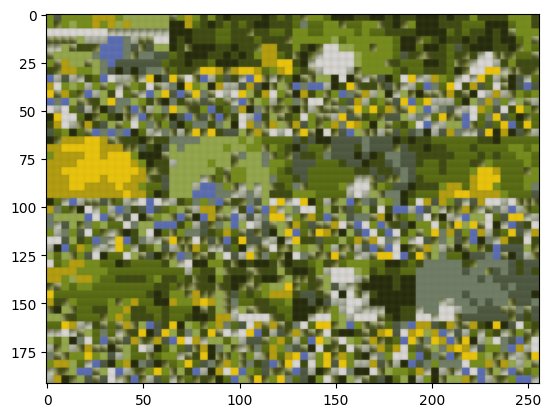

<div class="alert alert-info" role="alert"><b>Analyzes are in blue boxes.</b> You should comment on your results in theses boxes (Is it good? Is it expected? Why do we get such result? Why is it different from the previous one? etc)
</div>


<div class="alert alert-success"> 
<b>Q7. Write the fit method.</b>
Then, train a model with a few layers as best as you can. Generate images and check that they are better than the initialization and maybe more coherent than the linear model.
</div>

x: (12, 128)


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [00:00<00:00, 281.97it/s]


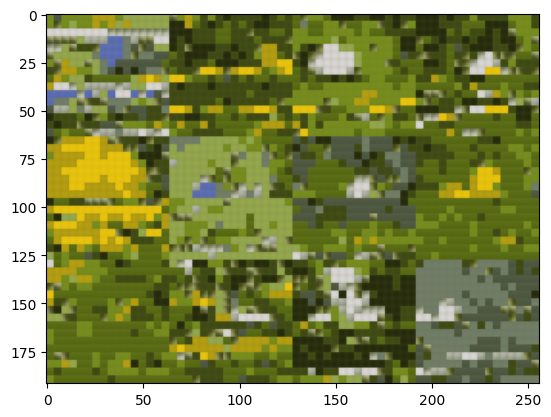


<div class="alert alert-info" role="alert"><b>Analyzes are in blue boxes.</b> You should comment on your results in theses boxes (Is it good? Is it expected? Why do we get such result? Why is it different from the previous one? etc)
</div>


<div class="alert alert-warning" role="alert"><b>(Optional Q8. Improve visual quality)</b> Improve visual quality by increasing the size of the dictionary (try 256, 1024, 4096). The model will be harder to train, requiring better innitialization and longer training. The problem becomes also more complex and the transformer may need higher dimension and depths. Transformers can be unstable to train, you can normalize $Q$ and $K$ to avoid some problems. Decreasing the learning rate during training can also help. Having a bigger models will take vvery long to optimize...
</div>